#### imports

In [1]:
# Data preprocessing
import numpy as np
import pandas as pd 

import datetime

import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import cv2
import tensorflow as tf
print(tf.__version__) # print the version of tensorflow
print(tf.config.list_physical_devices('GPU')) # check if gpu is available

from sklearn.model_selection import train_test_split

# importing tqdm
from tqdm import tqdm


import keras
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, InputLayer , Activation , ZeroPadding2D , AveragePooling2D ,Resizing ,Rescaling
from keras.metrics import categorical_crossentropy , categorical_accuracy
from keras.optimizers import SGD , Adam , RMSprop 


c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# import os

# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"


In [3]:
data_dir = 'COVID-19_Radiography_Dataset'


batch_size = 64
# img_height = 128
# img_width = 128
# IMG_SIZE = 227 # for AlexNet
IMG_SIZE = 224 # for VGG-NET , inception_resnet_v2

num_classes = 4

class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
# class_names = ['COVID','Normal']


#### helper functions

In [4]:
# helper functions 
def read_img(img):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def show_image(image, title='Image', cmap_type='gray', bgr2rgb=False):
    if bgr2rgb:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.show()



def plot_model_metrics(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    
    
#       label = (label_batch[i])
#   plt.title(class_names[np.argmax(label)])
    
    
    
def show_predictions(model):
        # model predicting on validation data and plotting the images with their predicted labels and actual labels
    image_batch, label_batch = next(iter(val_ds))
    # image_batch, label_batch = val_ds.batch(2)
    predicted_batch = model.predict(image_batch)
    predicted_id = np.argmax(predicted_batch, axis=-1)
    # print(predicted_id)
    plt.figure(figsize=(15, 15))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')
        label = np.argmax(label_batch[i])
        predicted_label = int(predicted_id[i])
        color = "blue" if predicted_label == label else "red"
        plt.title(
            f'{class_names[label]} | {class_names[predicted_label]}', color=color, fontsize=10)
        plt.axis("off")
    _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
    plt.show()
# tensorboard callback



log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)



resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2), 
#   tf.keras.layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
#   tf.keras.layers.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])



#### preprocessing data

##### method 1 of processing data  \\\\ NOT USED

In [4]:
x , y = [],[]
for path in os.listdir(data_dir):
    for img in os.listdir(os.path.join(data_dir,path)):
        img = cv2.imread(os.path.join(data_dir,path,img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        x.append(img)
        y.append(class_names.index(path))


In [5]:
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)
print(set(y))

(21165, 227, 227)
(21165,)
{0, 1, 2, 3}


In [6]:
# split data into train and test
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=42 , shuffle=True)

In [7]:

data_dict = {'x_train': x_train,
             'y_train': y_train,
             'x_test': x_test,
             'y_test': y_test}
np.save('data_dict_227.npy', data_dict)


In [8]:
data_dict_ = np.load('data_dict_227.npy', allow_pickle=True).item()
x_train = data_dict_['x_train']
y_train = data_dict_['y_train']
x_test = data_dict_['x_test']
y_test = data_dict_['y_test']
del data_dict_

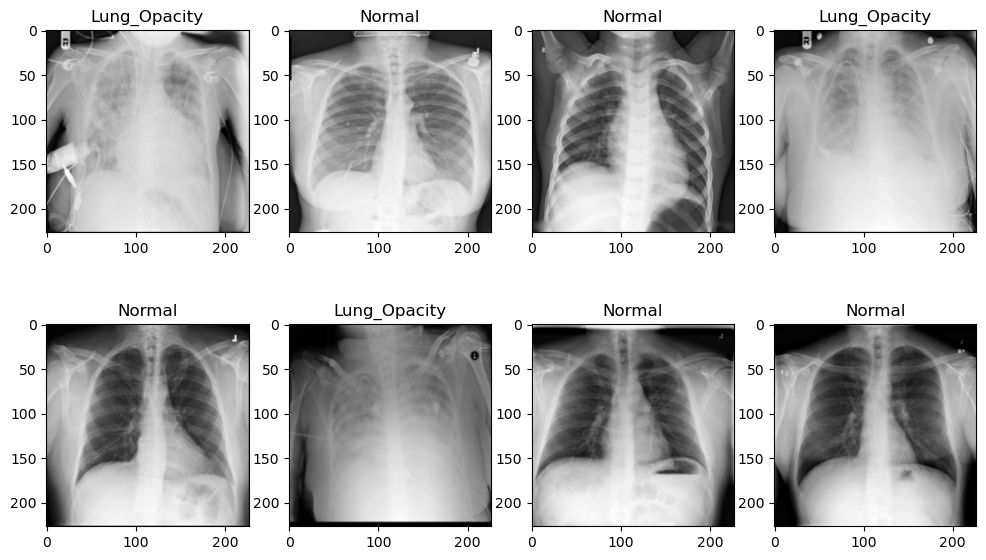

In [10]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(12, 7))
for i in range(8):
  ind = random.randint(0, len(x_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(x_train[ind] , cmap='gray')
  plt.title(class_names[y_train[ind]])


In [11]:
# importing one hot encoding from keras
def preprocess_data(X, y):
  # convert X from list to array
  x = np.array(X)

  # convert integer values of X into floats
  X = X.astype(np.float32)

  # normalization
  X = X/255.0

  # one-hot encoding the labels
  y = to_categorical(np.array(y))

  return X, y


(x_train, y_train) = preprocess_data(x_train, y_train)
(x_test, y_test) = preprocess_data(x_test, y_test)


##### another way to load data from directory using keras 


In [8]:
# another way to load data from directory using keras 
from tensorflow import keras
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory  = data_dir,
    labels = 'inferred',
    label_mode='categorical',
    class_names= class_names,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    # color_mode='grayscale',
    batch_size=batch_size)  

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory  = data_dir,
    labels = 'inferred',
    label_mode='categorical',
    class_names= class_names,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    # color_mode='grayscale',
    batch_size=batch_size)  


Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [9]:
train_ds


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    # print((labels_batch))
    break


(64, 224, 224, 3)
(64, 4)


In [11]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size= AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


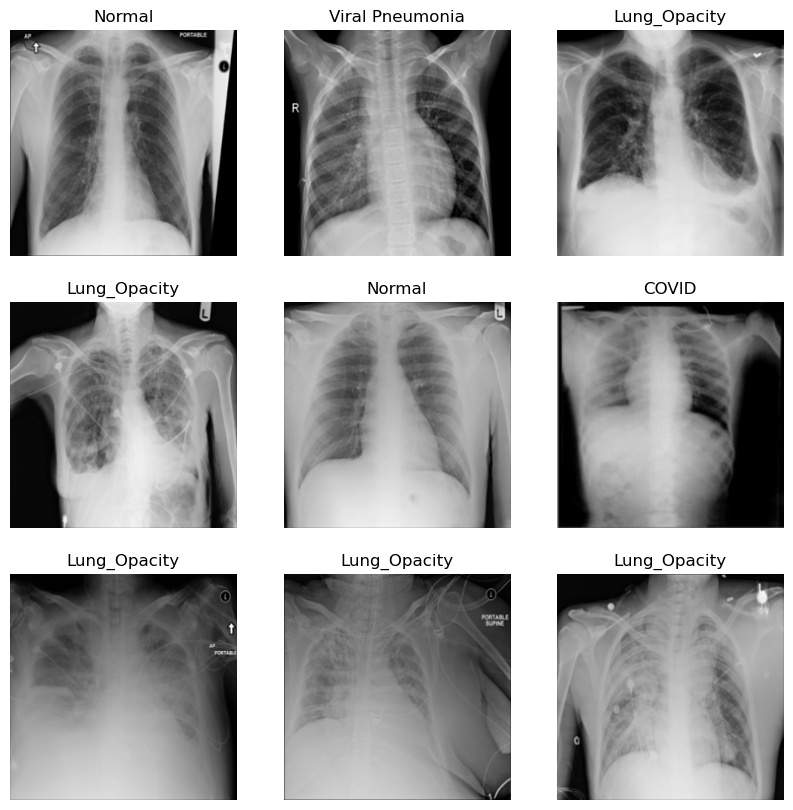

In [12]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')
  label = (label_batch[i])
  plt.title(class_names[np.argmax(label)])
  plt.axis("off")


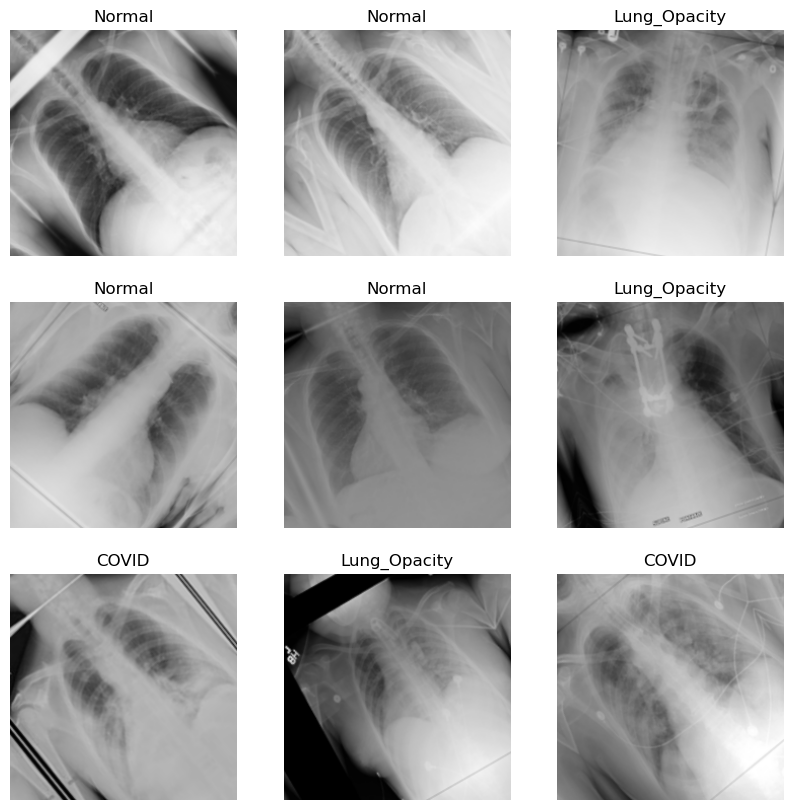

In [13]:
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  
  aug_batch = data_augmentation(image_batch, training=True)
  
  plt.imshow(aug_batch[i].numpy().astype("uint8"), cmap='gray')
  label = (label_batch[i])
  plt.title(class_names[np.argmax(label)])
  plt.axis("off")


#### simple cnn model

In [10]:


simple_cnn_model = tf.keras.Sequential([
    InputLayer(input_shape=(256 , 256 ,3)),

    resize_and_rescale,
    data_augmentation,
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),

    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),

    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes , activation='softmax')
])


In [11]:
simple_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 227, 227, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 conv2d (Conv2D)             (None, 225, 225, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      9248      
                                                      

In [12]:
simple_cnn_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])


In [13]:
epochs = 50

simple_cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback])


# model.summary()



Epoch 1/50
133/133 [==============================] - 33s 212ms/step - loss: 1.2971 - accuracy: 0.4965 - val_loss: 1.1757 - val_accuracy: 0.5377
Epoch 2/50
133/133 [==============================] - 28s 209ms/step - loss: 0.9652 - accuracy: 0.5969 - val_loss: 0.9818 - val_accuracy: 0.6251
Epoch 3/50
133/133 [==============================] - 28s 209ms/step - loss: 0.9012 - accuracy: 0.6261 - val_loss: 0.9779 - val_accuracy: 0.6449
Epoch 4/50
133/133 [==============================] - 28s 211ms/step - loss: 0.8668 - accuracy: 0.6420 - val_loss: 0.9808 - val_accuracy: 0.6102
Epoch 5/50
133/133 [==============================] - 27s 205ms/step - loss: 0.8469 - accuracy: 0.6505 - val_loss: 0.8700 - val_accuracy: 0.6667
Epoch 6/50
133/133 [==============================] - 27s 202ms/step - loss: 0.8192 - accuracy: 0.6588 - val_loss: 0.8372 - val_accuracy: 0.6764
Epoch 7/50
133/133 [==============================] - 27s 198ms/step - loss: 0.7890 - accuracy: 0.6776 - val_loss: 0.8385 - val_ac

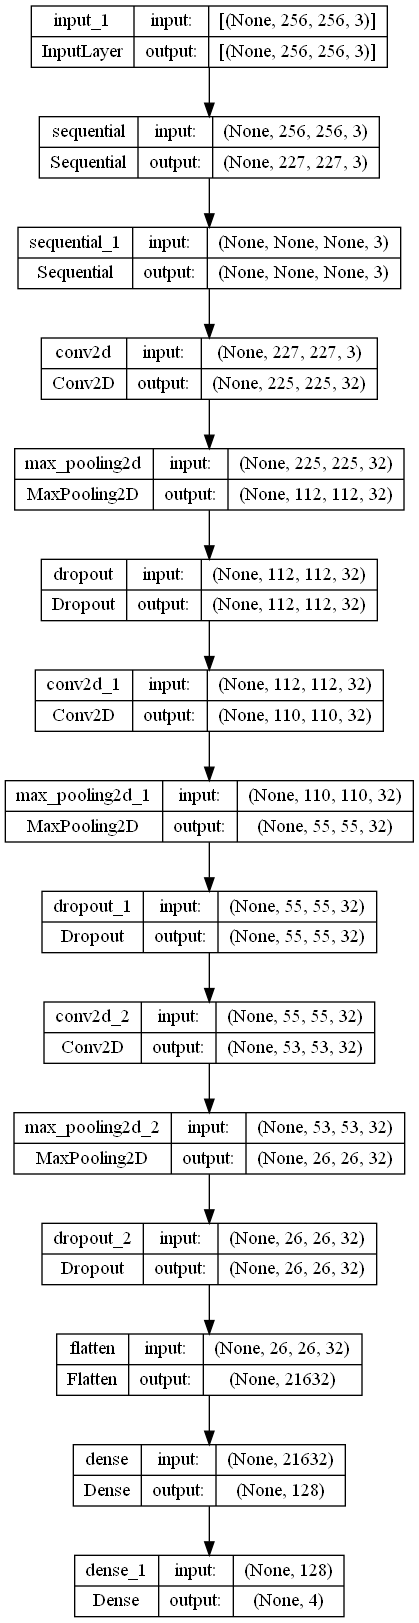

In [14]:
plot_model(simple_cnn_model, show_shapes=True, show_layer_names=True , to_file='simple_cnn_model.png')


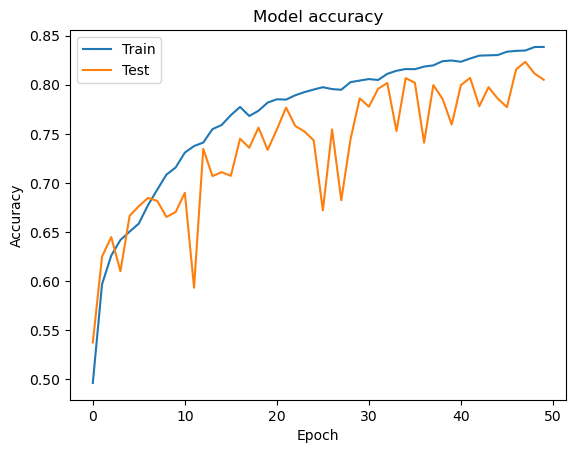

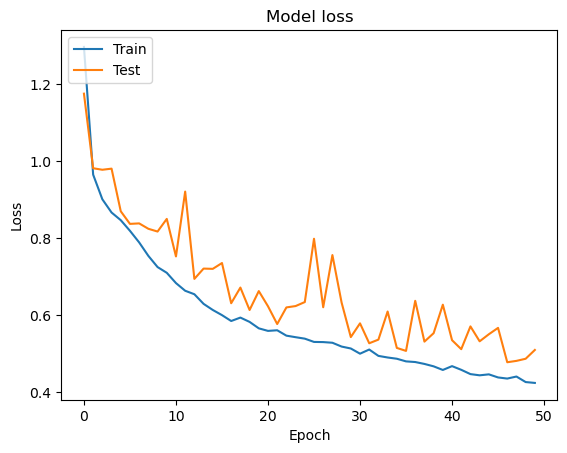

In [15]:
plot_model_metrics(simple_cnn_model.history)

# show_predictions(simple_cnn_model)


4/4 [==============================] - 0s 7ms/step


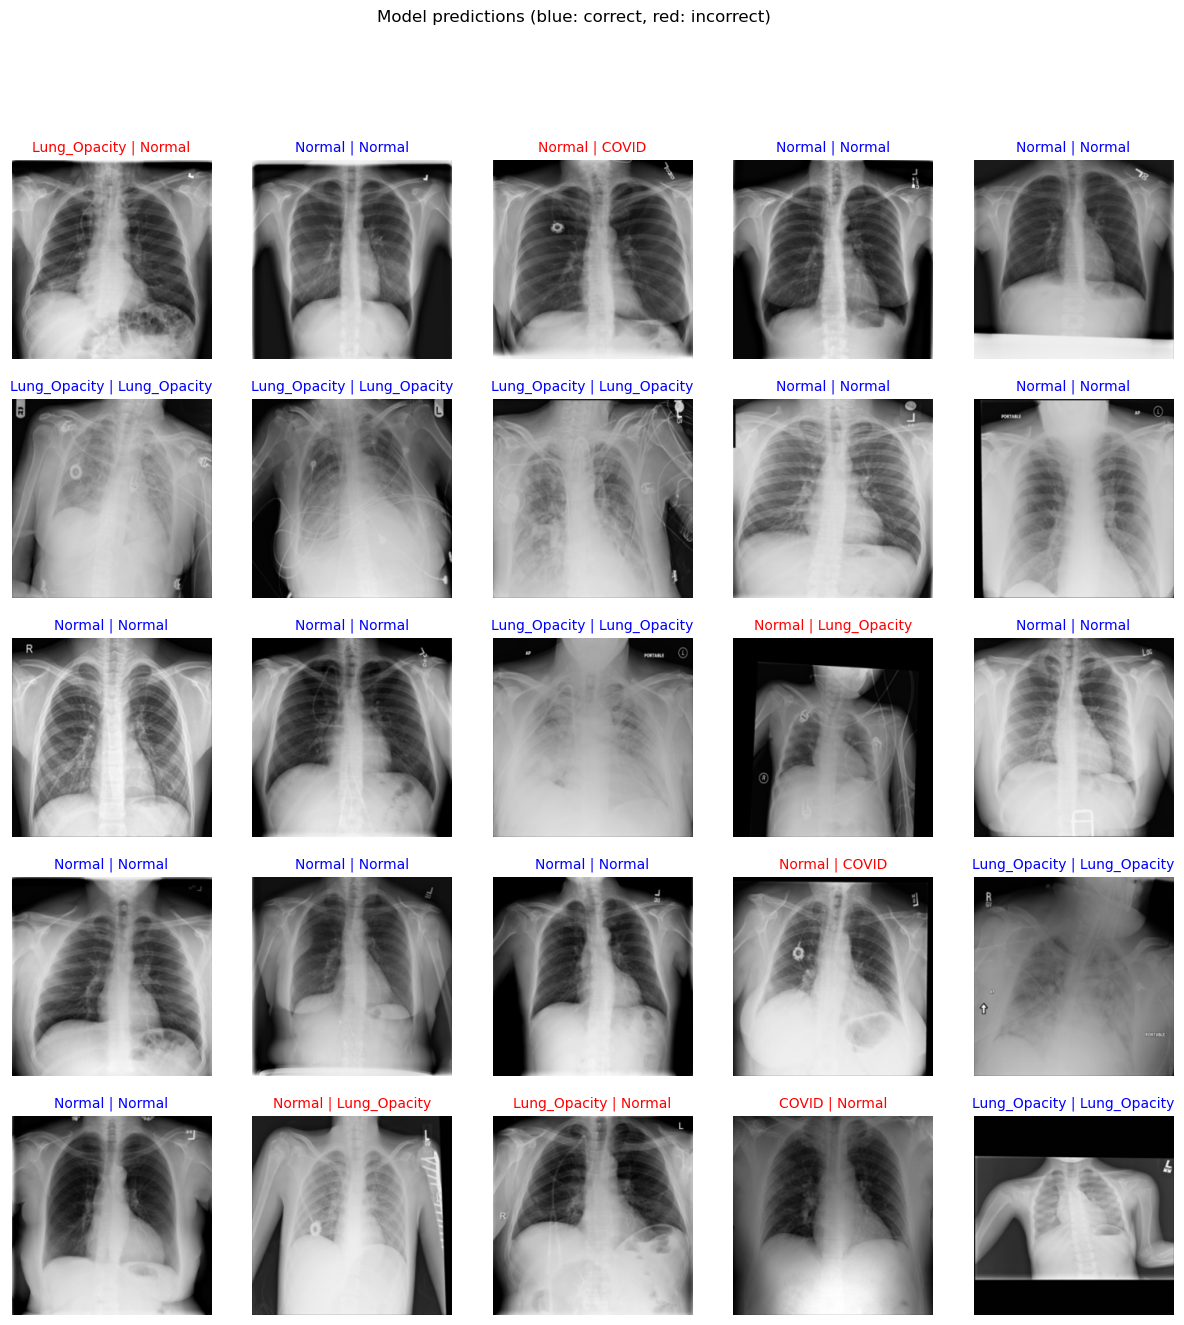

In [16]:
show_predictions(simple_cnn_model)


In [17]:
simple_cnn_model.save(f'simple_cnn_model_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5')
# simple_cnn_model = tf.keras.models.load_model('simple_cnn_model.h5')

#### alex net

In [18]:
# ALEX net


alex_net = Sequential([
InputLayer(input_shape=(256 , 256 ,3)),

resize_and_rescale,
data_augmentation,
# layer 1: convolutional layer + max-pooling layer
Conv2D(filters=96, kernel_size=(11, 11), strides=4, padding='valid', activation='relu'),
MaxPooling2D(pool_size=(3, 3), strides=2),

# layer 2: convolutional layer + max-pooling layer 
Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', activation = 'relu'),
MaxPooling2D(pool_size = (3,3), strides = 2),

# layers 3-5: three convolutional layers + 1 max-pooling layer
Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
MaxPooling2D(pool_size=(3, 3), strides=2),

# layers 6 - 8: two fully connected hidden layers and one fully connected output layer
Flatten(),
Dense(4096, activation='relu'),
Dropout(0.5),
Dense(4096, activation='relu'),
Dropout(0.5),
Dense(num_classes , activation='softmax')])

alex_net.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 227, 227, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                  

In [19]:
alex_net.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])



In [20]:
epochs = 50
    
alex_net.fit(   
    train_ds,   
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback])


Epoch 1/50
133/133 [==============================] - 36s 230ms/step - loss: 1.2476 - accuracy: 0.5013 - val_loss: 1.0926 - val_accuracy: 0.5545
Epoch 2/50
133/133 [==============================] - 29s 212ms/step - loss: 0.8942 - accuracy: 0.6398 - val_loss: 0.8472 - val_accuracy: 0.6622
Epoch 3/50
133/133 [==============================] - 28s 208ms/step - loss: 0.8181 - accuracy: 0.6662 - val_loss: 0.9169 - val_accuracy: 0.6445
Epoch 4/50
133/133 [==============================] - 28s 208ms/step - loss: 0.7697 - accuracy: 0.6839 - val_loss: 0.7090 - val_accuracy: 0.7167
Epoch 5/50
133/133 [==============================] - 28s 206ms/step - loss: 0.7009 - accuracy: 0.7152 - val_loss: 0.6028 - val_accuracy: 0.7638
Epoch 6/50
133/133 [==============================] - 28s 207ms/step - loss: 0.6699 - accuracy: 0.7286 - val_loss: 0.6412 - val_accuracy: 0.7300
Epoch 7/50
133/133 [==============================] - 28s 209ms/step - loss: 0.6462 - accuracy: 0.7431 - val_loss: 0.6036 - val_ac

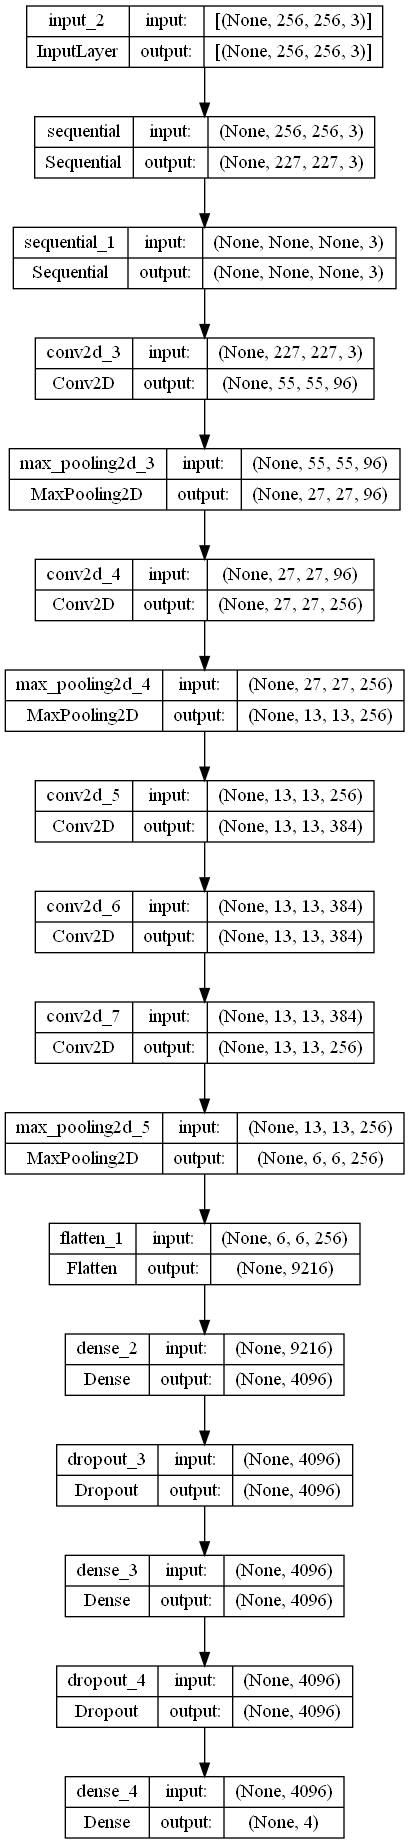

In [21]:
plot_model(alex_net, show_shapes=True, show_layer_names=True , to_file='alex_net.png')


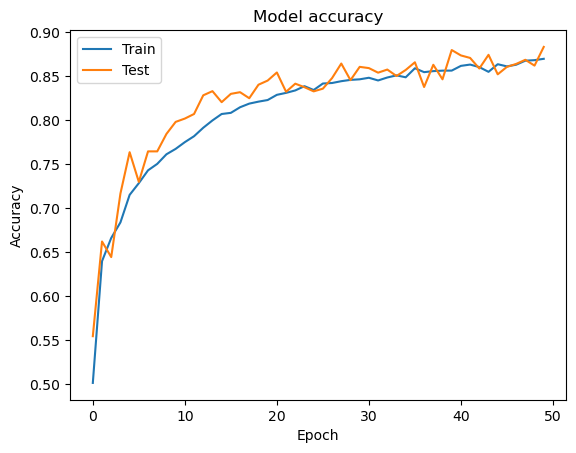

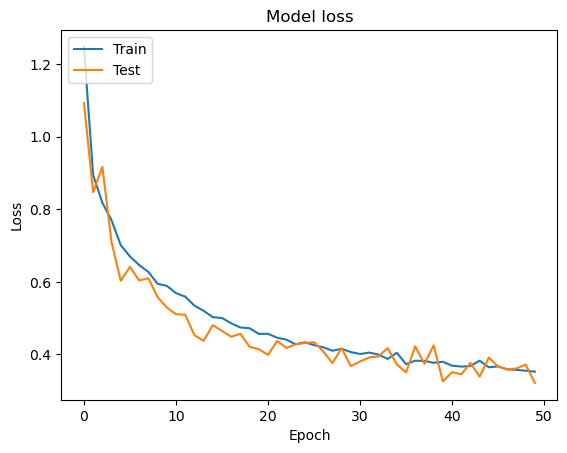

In [22]:
plot_model_metrics(alex_net.history)


4/4 [==============================] - 1s 13ms/step


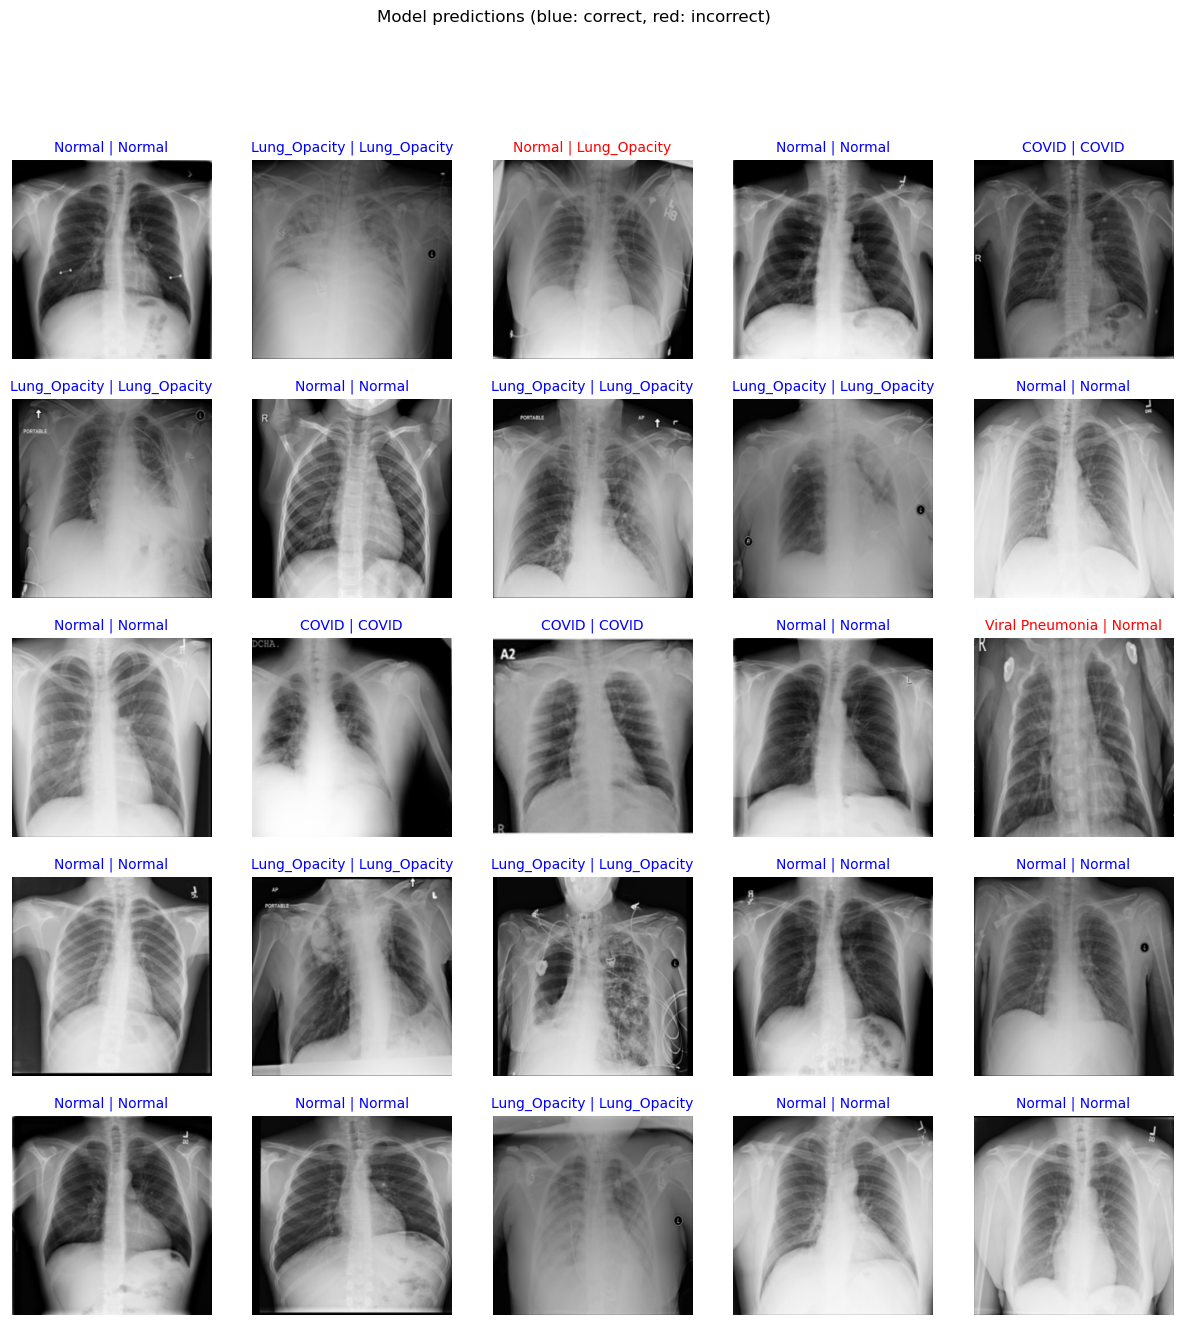

In [23]:
show_predictions(alex_net)

In [24]:
# saving the model with current timestamp
alex_net.save(f'alex_net_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5')
# del alex_net


In [25]:
# loading the model 
# alex_net = tf.keras.models.load_model('alex_net_20220930-103823.h5')


#### VGG net

In [19]:
vgg_model = Sequential([
InputLayer(input_shape=(224 , 224 ,3)),
Rescaling(1./255),
Conv2D(64, 3, strides=1, padding='same'),
Activation('relu'),
Conv2D(64, 3, strides=1, padding='same'),
Activation('relu'),
MaxPooling2D(2, strides=2),

Conv2D(128, 3, strides=1, padding='same'),
Activation('relu'),
Conv2D(128, 3, strides=1, padding='same'),
Activation('relu'),
MaxPooling2D(2, strides=2),


Conv2D(256, 3, strides=1, padding='same'),
Activation('relu'),
Conv2D(256, 3, strides=1, padding='same'),
Activation('relu'),
Conv2D(256, 1, strides=1, padding='same'),
Activation('relu'),
MaxPooling2D(2, strides=2),


Conv2D(512, 3, strides=1, padding='same'),
Activation('relu'),
Conv2D(512, 3, strides=1, padding='same'),
Activation('relu'),
Conv2D(512, 1, strides=1, padding='same'),
Activation('relu'),
MaxPooling2D(2, strides=2),


Conv2D(512, 3, strides=1, padding='same'),
Activation('relu'),
Conv2D(512, 3, strides=1, padding='same'),
Activation('relu'),
Conv2D(512, 1, strides=1, padding='same'),
Activation('relu'),
MaxPooling2D(2, strides=2),

Flatten(),
Dense(4096, activation='relu'),
Dropout(0.5),
Dense(4096, activation='relu'),
Dropout(0.5),
Dense(4, activation='softmax')])
vgg_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 activation_26 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 activation_27 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                      

In [9]:
vgg_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [20]:
# had to reduce batch size to 16 for the vgg model  to fit in the memory

epochs = 10
    
vgg_model.fit(   
    train_ds,   
    validation_data=val_ds,
    epochs=epochs,
    )

# the vgg couldnt fit the data because of the 129 million parameters takes alot of time to train so i will use a pretrained model later

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

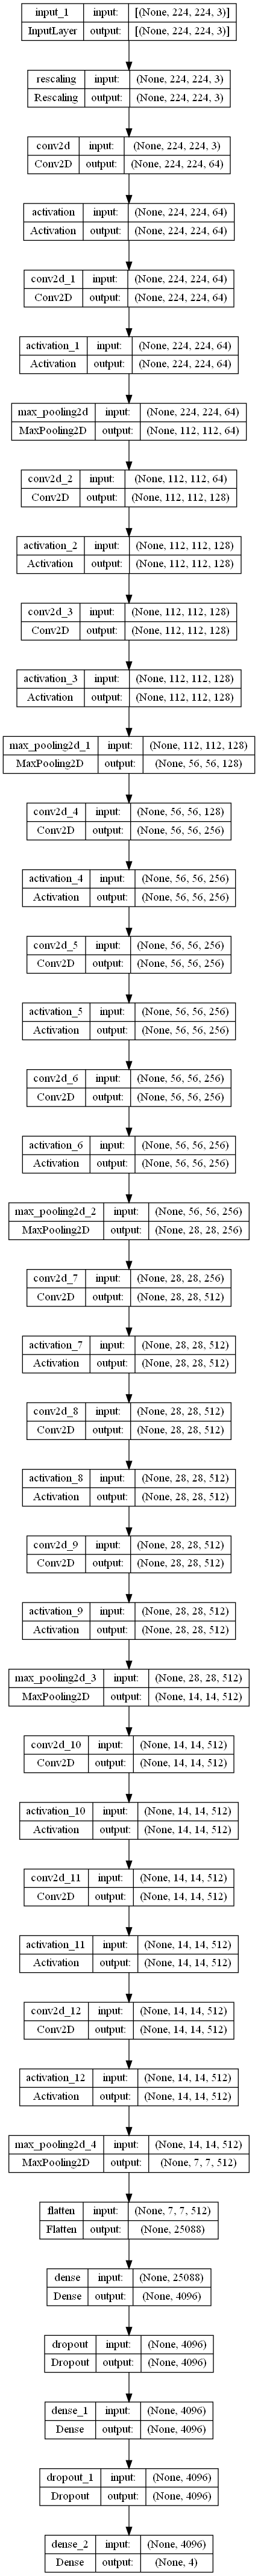

In [13]:
plot_model(vgg_model, show_shapes=True, show_layer_names=True , to_file='vgg_model.png')


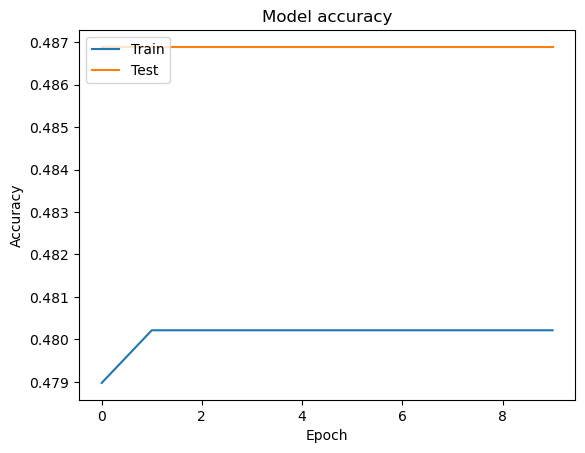

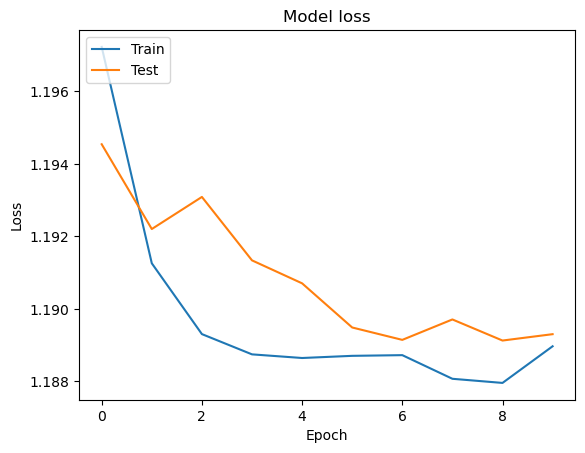

In [14]:
plot_model_metrics(vgg_model.history)


1/1 [==============================] - 1s 602ms/step


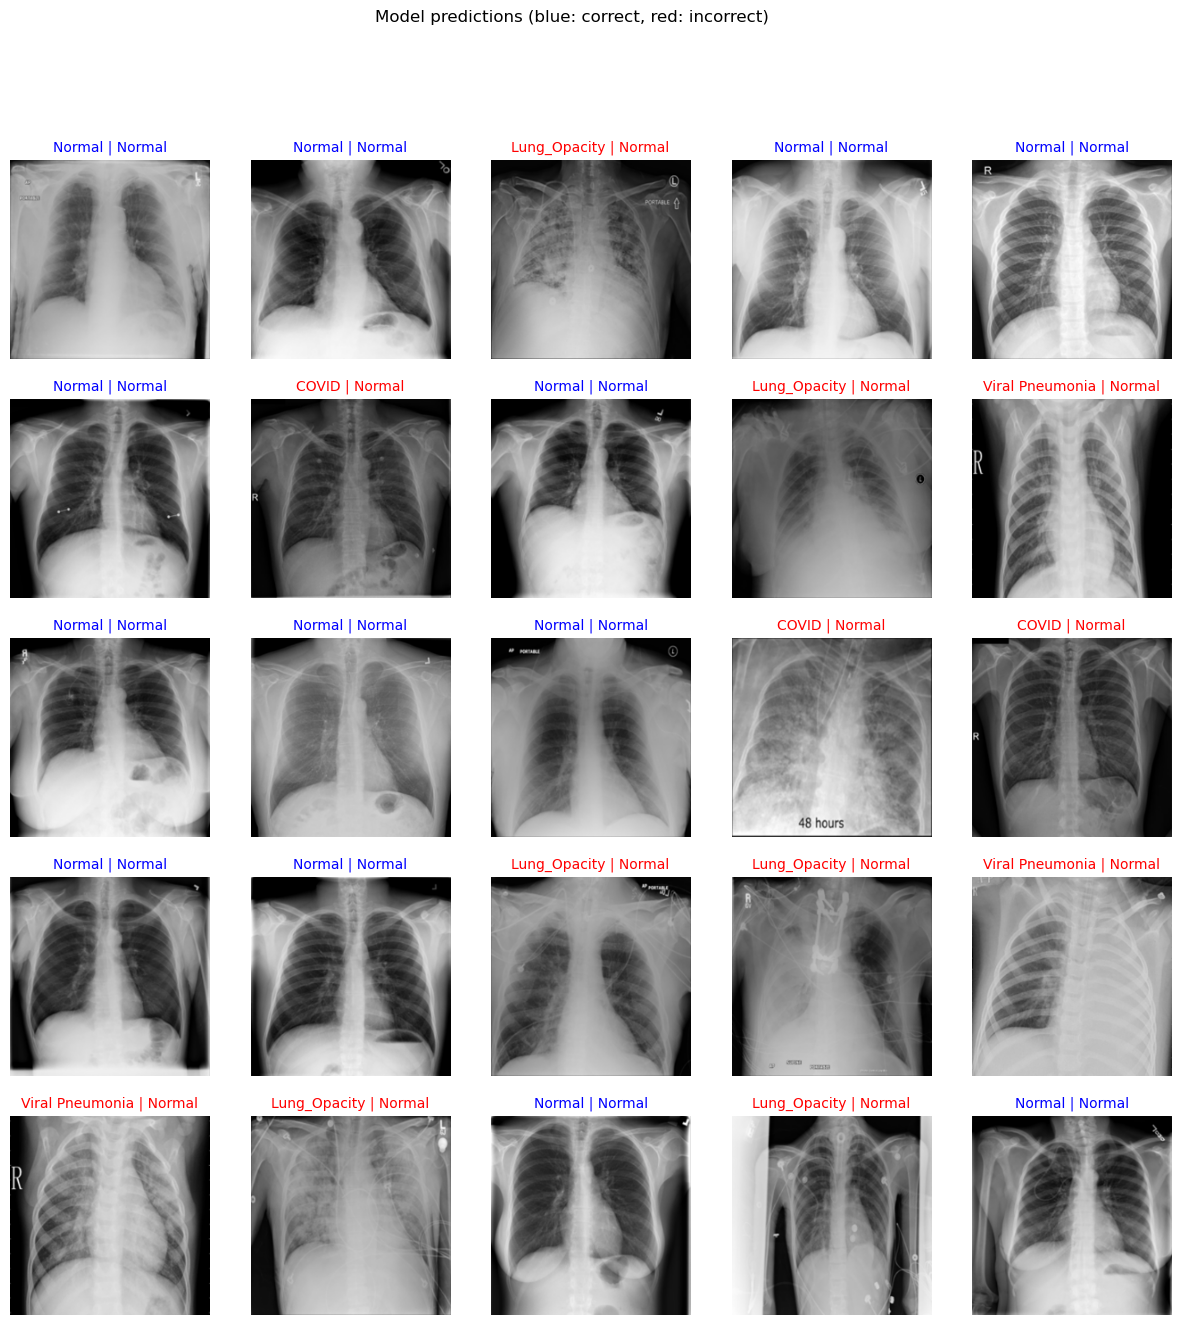

In [15]:
show_predictions(vgg_model)

In [18]:
# saving the model with current timestamp
vgg_model.save(f'vgg_model{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5')
# del alex_net


In [ ]:
# loading the model 
# vgg_model = tf.keras.models.load_model('vgg_model-103823.h5')


#### inception resnet

In [11]:

engine = tf.keras.applications.InceptionResNetV2(
    # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
    include_top = False,

    # Use Imagenet weights
    weights = 'imagenet',

    # Define input shape to 224x224x3
    input_shape = (224, 224, 3),

    # Set classifier activation to sigmoid
    classifier_activation = 'sigmoid'
)

In [12]:

x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
out = tf.keras.layers.Dense(4, activation = 'softmax', name = 'dense_output')(x)


# Build the Keras model

inception_resnet_v2 = tf.keras.models.Model(inputs = engine.input, outputs = out)


inception_resnet_v2.compile(
    # Set optimizer to Adam(0.001)
    optimizer = tf.keras.optimizers.Adam(0.001),

    # Set loss to binary crossentropy
    loss = 'categorical_crossentropy',

    # Set metrics to accuracy
    metrics = ['accuracy']
)

In [13]:

# before training we need to rescale train , test dataset by 1/255

train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))




In [15]:



epochs = 5
inception_resnet_v2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback])




Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_136/Conv2D' defined at (most recent call last):
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\traitlets\config\application.py", line 978, in launch_instance
      app.start()
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Shehab\AppData\Local\Temp\ipykernel_17368\2861531437.py", line 2, in <module>
      inception_resnet_v2.fit(
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\layers\convolutional\base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\keras\layers\convolutional\base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv2d_136/Conv2D'
OOM when allocating tensor with shape[64,12,12,192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_136/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_67123]

#### other